# Web Scraping for Indeed.com & Predicting Salaries

In this project, we will practice two major skills: collecting data by scraping a website and then building a binary predictor with Logistic Regression.

We are going to collect salary information on data science jobs in a variety of markets. Then using the location, title and summary of the job we will attempt to predict the salary of the job. For job posting sites, this would be extraordinarily useful. While most listings DO NOT come with salary information (as you will see in this exercise), being to able extrapolate or predict the expected salaries from other listings can help guide negotiations.

Normally, we could use regression for this task; however, we will convert this problem into classification and use Logistic Regression.

- Question: Why would we want this to be a classification problem?
- Answer: While more precision may be better, there is a fair amount of natural variance in job salaries - predicting a range be may be useful.

Therefore, the first part of the assignment will be focused on scraping Indeed.com. In the second, we'll focus on using listings with salary information to build a model and predict additional salaries.

### Scraping job listings from Indeed.com

We will be scraping job listings from Indeed.com using BeautifulSoup. Luckily, Indeed.com is a simple text page where we can easily find relevant entries.

First, look at the source of an Indeed.com page: (http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10")

Notice, each job listing is underneath a `div` tag with a class name of `result`. We can use BeautifulSoup to extract those. 

#### Setup a request (using `requests`) to the URL below. Use BeautifulSoup to parse the page and extract all results (HINT: Look for div tags with class name result)

In [1]:
URL = "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10"

In [2]:
import requests
import bs4
from bs4 import BeautifulSoup

In [3]:
r = requests.get(URL)

In [4]:
bs = BeautifulSoup(r.content, "lxml")
#print bs.prettify()

In [5]:
bs.select('h1')

[<h1><font size="+1">data scientist $20,000 jobs in New York State</font></h1>]

In [6]:
results = bs.findAll('div', {"class" : " row  result"})

In [7]:
#results = bs.findAll('div', {"class" : "sjcl"})

Let's look at one result more closely. A single `result` looks like

```
<div class=" row result" data-jk="2480d203f7e97210" data-tn-component="organicJob" id="p_2480d203f7e97210" itemscope="" itemtype="http://schema.org/JobPosting">
<h2 class="jobtitle" id="jl_2480d203f7e97210">
<a class="turnstileLink" data-tn-element="jobTitle" onmousedown="return rclk(this,jobmap[0],1);" rel="nofollow" target="_blank" title="AVP/Quantitative Analyst">AVP/Quantitative Analyst</a>
</h2>
<span class="company" itemprop="hiringOrganization" itemtype="http://schema.org/Organization">
<span itemprop="name">
<a href="/cmp/Alliancebernstein?from=SERP&amp;campaignid=serp-linkcompanyname&amp;fromjk=2480d203f7e97210&amp;jcid=b374f2a780e04789" target="_blank">
    AllianceBernstein</a></span>
</span>
<tr>
<td class="snip">
<nobr>$117,500 - $127,500 a year</nobr>
<div>
<span class="summary" itemprop="description">
C onduct quantitative and statistical research as well as portfolio management for various investment portfolios. Collaborate with Quantitative Analysts and</span>
</div>
</div>
</td>
</tr>
</table>
</div>
```

While this has some more verbose elements removed, we can see that there is some structure to the above:
- The salary is available in a `nobr` element inside of a `td` element with `class='snip`.
- The title of a job is in a link with class set to `jobtitle` and a `data-tn-element="jobTitle`.  
- The location is set in a `span` with `class='location'`. 
- The company is set in a `span` with `class='company'`. 

### Write 4 functions to extract each item: location, company, job, and salary.

example: 
```python
def extract_location_from_result(result):
    return result.find ...
```


- Make sure these functions are robust and can handle cases where the data/field may not be available.
- Test the functions on the results above

In [8]:
company = bs.select('span.company')
company[3].text.strip()

u'PlaceIQ'

In [9]:
location = bs.select('span.location')
location[3].text.strip()

u'New York, NY'

In [10]:
job = bs.findAll('a[data-tn-element="jobTitle"]')
job

[]

In [44]:
"""
#template
def extract_text(el):
    if el:
        return el.text.strip()
    else:
        return ''
"""

In [46]:
"""
def get_company_from_result(result):
    return extract_text(result.find('span', {'class' : 'company'}))
print get_company_from_result(bs)
"""

AbilTo, Inc


## Per new instructions the rest of the assignment will be done with an imported csv file.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv('../assets/indeed-scraped-job-postings.csv')
df.head()

,city,company,salary,summary,title,parsed_salary
0,San+Francisco,MarkMonitor,"$180,000 a year","Data skills (SQL, Hive, Pig). Applying machine...",Data Scientist,180000.0
1,San+Francisco,Workbridge Associates,"$130,000 - $180,000 a year",3+ years of industry experience in a data scie...,Senior Data Scientist,155000.0
2,San+Francisco,Mines.io,"$80,000 - $120,000 a year",We are looking for a data scientist/developer ...,Full-Stack Data Scientist,100000.0
3,San+Francisco,Workbridge Associates,"$150,000 - $180,000 a year",In this position you will share programming an...,Data Scientist,165000.0
4,San+Francisco,Smith Hanley Associates,"$140,000 a year","This person will recruit, build and lead a tea...",Data Scientist,140000.0


In [3]:
df.dtypes

city              object
company           object
salary            object
summary           object
title             object
parsed_salary    float64
dtype: object

In [4]:
df.shape

(4791, 6)

In [5]:
#removing the salary column, since we have a parsed salary column and removing summary since we will not be using it.
del df['salary']
del df['summary']

In [6]:
df2 = df

There are a significant amount of duplicate roles that will skew our data predictions if left in.

In [7]:
df2 = df2.drop_duplicates()

In [10]:
df2.shape

(224, 4)

In reviewing the salary column, it became apparent that there were both yearly and monthly salaries.  In order to resolve this, we can make an assumption that any salary under $20k is a monthly salary, as minimum wage would put a yearly salary above that.  

In [11]:
#Assuming that any salary under $20k is a monthly salary, we can use the following for loop to convert to a yearly
salary_list = []
for i in df['parsed_salary']:
    if i < 20000.0:
        salary_list.append(i*12)
    else:
        salary_list.append(i)

In [12]:
df['parsed_salary'] = salary_list

In [13]:
df.head()

,city,company,title,parsed_salary
0,San+Francisco,MarkMonitor,Data Scientist,180000.0
1,San+Francisco,Workbridge Associates,Senior Data Scientist,155000.0
2,San+Francisco,Mines.io,Full-Stack Data Scientist,100000.0
3,San+Francisco,Workbridge Associates,Data Scientist,165000.0
4,San+Francisco,Smith Hanley Associates,Data Scientist,140000.0


In [14]:
#Removing the '+' in the city column and replacing it with a space
df2['city'] = df2['city'].map(lambda x: x.replace('+', ' '))

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [15]:
df2.head()

,city,company,title,parsed_salary
0,San Francisco,MarkMonitor,Data Scientist,180000.0
1,San Francisco,Workbridge Associates,Senior Data Scientist,155000.0
2,San Francisco,Mines.io,Full-Stack Data Scientist,100000.0
3,San Francisco,Workbridge Associates,Data Scientist,165000.0
4,San Francisco,Smith Hanley Associates,Data Scientist,140000.0


Exploring the data in order to determine the columns I will be using in my regression

In [16]:
set(df2['city'])

{'Austin', 'Chicago', 'New York', 'San Francisco', 'Seattle'}

In [17]:
set(df2['company'])

{'3coast',
 "ADMIN FOR CHILDREN'S SVCS",
 'All-In Analytics',
 'AllianceBernstein',
 'Analytic Recruiting',
 'AreteX Engineering',
 'Atrium Staffing',
 'Averity',
 'Brilent',
 'California State University',
 'Clinical Management Consultants',
 'Corporate Labs Technology',
 'DEPARTMENT OF FINANCE',
 'DEPT OF ENVIRONMENT PROTECTION',
 'DEPT OF HEALTH/MENTAL HYGIENE',
 'Datacom Technology Group',
 'Department Of Veterans Affairs',
 'Department of the Navy',
 'Dept of State Health Services',
 'Econtetni',
 'Emoters Robotics',
 'Empiric Solutions',
 'Etech Hi Inc.',
 'Execsolution, Inc.',
 'FIRE DEPARTMENT',
 'Food Management Search',
 'Galvanize',
 'HOUSING PRESERVATION & DVLPMNT',
 'HRA/DEPT OF SOCIAL SERVICES',
 'HSF Consulting',
 'Harvey Nash USA',
 'Health Research Incorporated',
 'Health, Department of',
 'Helix Sleep',
 'Hire Solutions Inc.',
 'Hirewell',
 'ITStaff Technical Resources',
 'Infinity Consulting Solutions',
 'Insurance Fund, State',
 'JE Compliance',
 'Jobspring Partners

In [18]:
set(df2['title'])

{'(Sr.) Statistical Consultant',
 'AVP/Quantitative Analyst',
 'Administrative Analyst/Specialist, Exempt I - Office of Rese...',
 'Administrative Assistant',
 'Analyst, Strategy & Insights \xe2\x80\x93 Custom Research',
 'Assistant Director Biostatistics',
 'Assistant Research Scientist (Virology) - 34114',
 'Associate Director Statistics Phase I',
 'Assurance Coordinator, Bureau of Sexually Transmitted Diseas...',
 'Big Data Engineer',
 'Business Analyst ( Data)',
 'Business Data Analyst',
 'Business Intelligence Data Scientist',
 'Business Intelligence Scientist',
 'CHARGE CAPTURE COORDINATOR',
 'CLINICAL LABORATORY TECHNICIAN 1',
 'COMPUTER MAINTENANCE TECHNICIAN 3',
 'CONTACT CENTER REPRESENTATIVE 1 - CANDIDATE BANK',
 'Chief Algorithm Developer (Signal Processing) - Wearables',
 'Child Welfare Analyst',
 'DATA ANALYST',
 'DRIVER-WAREHOUSE WORKER',
 'Data Analyst / Scientist',
 'Data Analyst, Bureau of Chronic Disease Prevention and Tobac...',
 'Data Engineer',
 'Data Engineer (Pa

### Save your results as a CSV

In [19]:
df2.to_csv('df2.csv')

## Predicting salaries using Logistic Regression

In [20]:
#### Load in the the data of scraped salaries

Using the df2 pandas dataframe per new instructions

In [21]:
df2.head()

,city,company,title,parsed_salary
0,San Francisco,MarkMonitor,Data Scientist,180000.0
1,San Francisco,Workbridge Associates,Senior Data Scientist,155000.0
2,San Francisco,Mines.io,Full-Stack Data Scientist,100000.0
3,San Francisco,Workbridge Associates,Data Scientist,165000.0
4,San Francisco,Smith Hanley Associates,Data Scientist,140000.0


Problem Statement:  Relocating for a job can be difficult. Knowing there is a bigger paycheck at the end of the road can ease the stress of that relocation. Here, we use logistic regression to predict whether a job will be above a median salary based on location, job title, and company.

#### We want to predict a binary variable - whether the salary was low or high. Compute the median salary and create a new binary variable that is true when the salary is high (above the median)

In [22]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn import cross_validation
from sklearn.linear_model import LogisticRegression

In [23]:
#originally calculated mean because median was returning a nan value - but left in code because it is good to know.
np.mean(df2['parsed_salary'])

94159.54484304933

I actually ran the below model on the mean and returned a .68 AUC score.  Ultimately, the median returned a much better model and fits the needs of what the project is asking for.

In [24]:
#there is a na value that is not allowing me to calculate the median, so I use dropna to resolve that.
df2 = df2.dropna()

In [25]:
np.median(df2['parsed_salary'])

88331.0

The below code will create the binary variable for salary.

In [26]:
salary_bin = [1 if x >= 8831 else 0 for x in df2['parsed_salary']] #rounded up from the median

Replacing the current 'parsed_salary' column with the new binary variable we created.

In [27]:
df2['parsed_salary'] = salary_bin

Converting cities to dummy variables to enable a logistical regression comparing city to salary.

In [28]:
df2 = df2.join(pd.get_dummies(df2['city']))

In [29]:
#quick check to make sure our work did what it was supposed to do.
df2.head()

,city,company,title,parsed_salary,Austin,Chicago,New York,San Francisco,Seattle
0,San Francisco,MarkMonitor,Data Scientist,1,0.0,0.0,0.0,1.0,0.0
1,San Francisco,Workbridge Associates,Senior Data Scientist,1,0.0,0.0,0.0,1.0,0.0
2,San Francisco,Mines.io,Full-Stack Data Scientist,1,0.0,0.0,0.0,1.0,0.0
3,San Francisco,Workbridge Associates,Data Scientist,1,0.0,0.0,0.0,1.0,0.0
4,San Francisco,Smith Hanley Associates,Data Scientist,1,0.0,0.0,0.0,1.0,0.0


#### Thought experiment: What is the baseline accuracy for this model?

In [30]:
lm = LogisticRegression()

lm.fit(df2[['Austin', 'Chicago', 'New York', 'San Francisco', 'Seattle']], df2['parsed_salary'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

The accuracy with the model with all features is 87.44% as shown by the code below:

In [31]:
feature_set = df2[['Austin', 'Chicago', 'New York', 'San Francisco', 'Seattle']]
print lm.score(feature_set, df2['parsed_salary'])

0.874439461883


In [32]:
#ran some tests to make sure my columns were formatted correctly.
#df2[['Austin', 'Chicago', 'New York', 'San Francisco', 'Seattle']].head()

In [33]:
#df2[['Austin', 'Chicago', 'New York', 'San Francisco', 'Seattle']].shape

In [34]:
#df2['parsed_salary'].shape

#### Create a Logistic Regression model to predict High/Low salary using statsmodel. Start by ONLY using the location as a feature. Display the coefficients and write a short summary of what they mean.

In [35]:
# Coefficients represent the log-odds. This includes the y-intercept. 
print lm.coef_
print lm.intercept_
print df2.parsed_salary.mean()

[[-1.87409854  1.56857982  2.2104682   1.08982195 -1.63160646]]
[ 1.36316498]
0.784753363229


The following code shows us some interesting data in regards to the odds of earning above the salary mean ($94,160.00) per city.  According to this, our greatest chance of earning above the mean salary point is in San Francisco, where your odds are at 4.79, as opposed to Austin where your odds are at .15.

In [36]:
# You can easily convert these into odds using numpy.exp()
print np.exp(lm.coef_)
print np.exp(lm.intercept_)
print df2.parsed_salary.mean()

[[ 0.15349327  4.79982674  9.11998535  2.97374456  0.19561507]]
[ 3.9085442]
0.784753363229


This model uses the cities as a feature set - converted to dummy variables - and attempts to predict the salary.

In [37]:
from sklearn.metrics import roc_curve, roc_auc_score

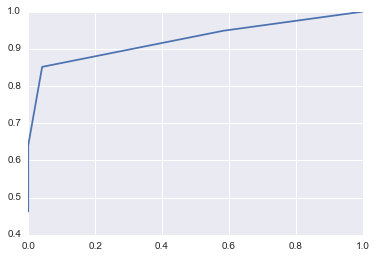

In [38]:
actuals = lm.predict(feature_set) 
probas = lm.predict_proba(feature_set)
plt.plot(roc_curve(df2['parsed_salary'], probas[:,1])[0], roc_curve(df2['parsed_salary'], probas[:,1])[1])

In [39]:
#print df2['parsed_salary'].head()
#print probas[:,1]

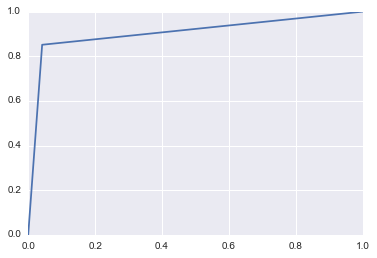

In [40]:
plt.plot(roc_curve(df2['parsed_salary'], actuals)[0], roc_curve(df2['parsed_salary'], actuals)[1])

The following calculates the area under these curves (AUC):

In [41]:
roc_auc_score(df2['parsed_salary'], lm.predict(feature_set))

0.90488095238095234

This shows us that this model is immensely accurate.  Showing that 90% of the time we will return a True Positive, and only 10% of the time we are going to get a False Positive.

The above code shows us that we can confidently predict salary based on location according to the database we have constructed and the model we created.  

#### Create a few new variables in your dataframe to represent interesting features of a job title.
- For example, create a feature that represents whether 'Senior' is in the title 
- or whether 'Manager' is in the title. 
- Then build a new Logistic Regression model with these features. Do they add any value? 


In [92]:
vp = df2[df2['title'].str.contains("VP","Vice President")]
senior = df2[df2['title'].str.contains("Sr","Senior")]
junior = df2[df2['title'].str.contains("JR")]
Intern = df2[df2['title'].str.contains("Intern")]
FullStack = df2[df2['title'].str.contains("Full Stack")]
manager = df2[df2['title'].str.contains("Manager")]
analyst = df2[df2['title'].str.contains("Analyst")]

In [90]:
vp

,city,company,title,parsed_salary,Austin,Chicago,New York,San Francisco,Seattle
5,San Francisco,HSF Consulting,VP of Data Services,1,0.0,0.0,0.0,1.0,0.0
22,San Francisco,3coast,VP - Predictive Modeling / Data Scientist,1,0.0,0.0,0.0,1.0,0.0
405,New York,AllianceBernstein,AVP/Quantitative Analyst,1,0.0,0.0,1.0,0.0,0.0
425,New York,Oliver James Associates,VP - Predictive Modeling Actuary,1,0.0,0.0,1.0,0.0,0.0
440,New York,Selby Jennings,VP Data Scientist,1,0.0,0.0,1.0,0.0,0.0
449,New York,3coast,VP - Predictive Modeling / Data Scientist,1,0.0,0.0,1.0,0.0,0.0


In [91]:
print "Vice President Titles: "
print vp['title'].count()
print "Senior Titles: "
print senior['title'].count()
print "Junior Titles: "
print junior['title'].count()
print "Interns: "
print Intern['title'].count()
print "Full Stack Titles: "
print FullStack['title'].count()
print "Manager Titles: "
print manager['title'].count()
print "Analyst Titles: "
print analyst['title'].count()

Vice President Titles: 
6
Senior Titles: 
4
Junior Titles: 
1
Interns: 
1
Full Stack Titles: 
1
Manager Titles: 
6
Analyst Titles: 
37


I chose to take a look at the model with the "analyst" variable as it was the most robust variable out of the data set.

In [100]:
lm2 = LogisticRegression()

lm2.fit(analyst[['Austin', 'Chicago', 'New York', 'San Francisco', 'Seattle']], analyst['parsed_salary'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Right away we can see an improvement in accuracy, which is to be expected, since we greatly reduced the amount of variables in the model.  The new accuracy is at 91.89%

In [104]:
feature_set = analyst[['Austin', 'Chicago', 'New York', 'San Francisco', 'Seattle']]
print lm.score(feature_set, analyst['parsed_salary'])

0.918918918919


In [101]:
print lm2.coef_
print lm2.intercept_
print analyst.parsed_salary.mean()

[[-0.82048264  0.60360446  1.42454299  0.17416692  0.        ]]
[ 1.38183174]
0.918918918919


In [102]:
print np.exp(lm.coef_)
print np.exp(lm.intercept_)
print analyst.parsed_salary.mean()

[[ 0.15349327  4.79982674  9.11998535  2.97374456  0.19561507]]
[ 3.9085442]
0.918918918919


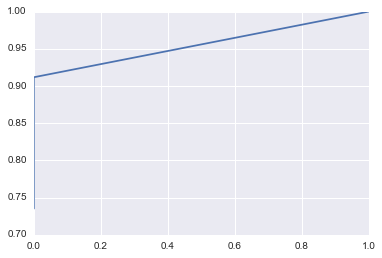

In [105]:
actuals = lm2.predict(feature_set) 
probas = lm2.predict_proba(feature_set)
plt.plot(roc_curve(analyst['parsed_salary'], probas[:,1])[0], roc_curve(analyst['parsed_salary'], probas[:,1])[1])

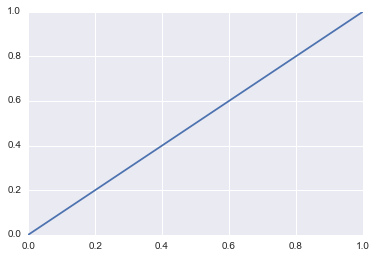

In [106]:
plt.plot(roc_curve(analyst['parsed_salary'], actuals)[0], roc_curve(analyst['parsed_salary'], actuals)[1])

The above charts, and below AUC score of 95% - at first glance - could lead us to believe we have improved our model.  However, what the charts show us is that we are actually overcompensating and therefore the results in the model with the analyst variable are not reliable.

In [107]:
roc_auc_score(analyst['parsed_salary'], lm.predict(feature_set))

0.95588235294117641